# Freq-E example usage 
Starting with a collection of text documents. This notebook walks through: 

1. Pre-processing text to be in a format suitable for input into freq-e

2. How to run freq-e to obtain prevalence estimates on the test set. 

In [1]:
from __future__ import division, print_function
import numpy as np 
import json
from sklearn.feature_extraction import DictVectorizer

In [2]:
import estimate; reload(estimate)
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-processing 
We will use the Yelp academic dataset as an example. The text representation will be unigram counts (e.g. "bag-of-words") which have already been processed and loaded. 

X : numpy.ndarray

y : numpy.ndarray 

In [4]:
def load_x_y_from_json(file_name): 
    count_dicts = []
    y = []
    for line in open(file_name): 
        dd = json.loads(line)
        counts = dd['counts'].copy()
        cc = dd['class']
        count_dicts.append(counts); y.append(cc)
    return count_dicts, np.array(y)  

In [5]:
def prune_vocab(X_train, dv_vocab): 
    #remove words that occur in <5 docs 
    xx=X_train.copy()
    xx[xx>0]=1
    w_df = np.asarray(xx.sum(0)).flatten()
    new_vocab_mask = w_df >= 5
    print("Orig vocab %d, pruned %d" % (len(w_df), np.sum(new_vocab_mask)))
    X_train = X_train[:,new_vocab_mask]
    dv_vocab = dv_vocab[new_vocab_mask]
    return X_train, dv_vocab, new_vocab_mask

In [6]:
#get train data 
dv = DictVectorizer()
train_count_dicts, y_train = load_x_y_from_json('example_data/train_yelp.json')
X_train = dv.fit_transform(train_count_dicts).toarray()
dv_vocab = np.array(dv.feature_names_)
X_train, dv_vocab, new_vocab_mask = prune_vocab(X_train, dv_vocab)
print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
assert X_train.shape[0] == y_train.shape[0]

Orig vocab 14791, pruned 3112
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(2000, 3112) (2000,)


In [7]:
def transform_test(test_count_dicts, new_vocab_mask): 
    X_test = dv.transform(test_count_dicts).toarray()
    X_test = X_test[:,new_vocab_mask]
    return X_test

In [8]:
# get test data (1 test group) 
# NOTE: the test group is the "inference" group in a real-word setting
# here we have labels on the test set, but in a real-word setting there 
# would most likely not be labels on the test set
test_count_dicts, y_test = load_x_y_from_json('example_data/test_yelp.json')
X_test = transform_test(test_count_dicts, new_vocab_mask)
print(type(X_test), type(y_test))
print(X_test.shape, y_test.shape)
assert X_test.shape[1] == X_train.shape[1]

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(2000, 3112) (2000,)


## Freq-e usage

### Training 
- In order to select the best discriminitive classifier, we will do a grid search over the L1 penalties for LogReg, evaluating on cross-entropy over 10 cross-validation folds 

In [9]:
freq_e = estimate.FreqEstimate(conf_level=0.95)
trained_model = freq_e.fit(X_train, y_train)
print(trained_model.C)

TRAINING DISCRIMINATIVE MODEL


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Training mean accuracy= 0.9635
0.5


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
# freq_e = estimate.FreqEstimate(conf_level=0.95)
# trained_model = freq_e.fit(X_train, y_train)
# print(trained_model.C)

### Inference
Returns (1) a point estimate of the class frequency/proportions and (2) a confidence interval for the point estimate. 

In [11]:
# here we can know the true proportions because we have access to the test labels 
print('TRUE')
print(np.mean(y_test))

TRUE
0.769


In [12]:
#naive method = PCC (probabilistic classify and count)
print('PCC')
print(np.mean(trained_model.predict_proba(X_test)[:, 1]))

PCC
0.769417372043


In [13]:
print(trained_model.predict_proba(X_test))

[[  4.19687308e-02   9.58031269e-01]
 [  9.99979949e-01   2.00506492e-05]
 [  1.40827808e-04   9.99859172e-01]
 ..., 
 [  3.27012055e-01   6.72987945e-01]
 [  1.09786745e-02   9.89021325e-01]
 [  9.97086156e-03   9.90029138e-01]]


In [14]:
print(trained_model.decision_function(X_test))

[  3.12795558 -10.81722898   8.8678318  ...,   0.72173038   4.50076118
   4.59806738]


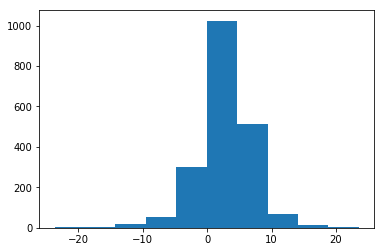

In [15]:
plt.hist(trained_model.decision_function(X_test))
plt.show()

In [17]:
print('FREQ-E ESTIMATED')
out = freq_e.predict_freq(trained_model, y_train, X_test)
print(out)

FREQ-E ESTIMATED
{'conf_interval': (0.748, 0.79500000000000004), 'point': 0.77200000000000002}


## Test group with really high prevalence 

In [18]:
test_count_dicts2, y_test2 = load_x_y_from_json('testgroup_zpoZ6WyQUYff18-z4ZU1mA/zpoZ6WyQUYff18-z4ZU1mA')
X_test2 = transform_test(test_count_dicts2, new_vocab_mask)
print(X_test2.shape, y_test2.shape)

(415, 3112) (415,)


In [19]:
print('TRUE')
print(np.mean(y_test2))

TRUE
0.968674698795


In [20]:
print('PCC')
print(np.mean(trained_model.predict_proba(X_test2)[:, 1]))

PCC
0.901939188497


In [21]:
print('FREQ-E ESTIMATED')
out = freq_e.predict_freq(trained_model, y_train, X_test2)
print(out)

FREQ-E ESTIMATED
{'conf_interval': (0.94400000000000006, 0.99199999999999999), 'point': 0.97299999999999998}


# Test group with really low prevalence 